In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [2]:
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'




In [60]:
y_axis = {
    'auc':{
        'lim':[0.75, 1.0],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[0.1, 0.85],
        'label':'AUPRC'
    },
    'ace_abs_logistic_log':{
        'lim':[-0.001, 0.078],
        'label':'Calibration'
    }
}

In [5]:
# Get baseline model
bl_df = pd.read_csv(f'{results_path}/clmbr/pretrained/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/uni_align_eval.csv')
bl_df['model'] = 'BL'


In [8]:
bl_df.query('split == "test"')

,Unnamed: 0,metric,lower_ci,med_ci,upper_ci,split,CLMBR,model
2,2,alignment,1.277014,1.325404,1.373794,test,BL,BL
3,3,uniformity,-1.149100,-1.065374,-0.981647,test,BL,BL


In [9]:
cl_grid = list(
    ParameterGrid(
        yaml.load(
            open(
                f"{os.path.join('/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/best','hyperparams')}.yml",
                'r'
            ),
            Loader=yaml.FullLoader
        )
    )
)

In [10]:
# Get best CL model by validation score for each task

cl_df = pd.DataFrame()
for i, hp in enumerate(cl_grid):
#         df = pd.read_csv(f'{results_path}/{task}/probes/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_{hp["batch_size"]}_lr_{hp["lr"]}_temp_{hp["temp"]}_pool_rand_day/eval.csv')
    cl_df = pd.read_csv(f'{results_path}/clmbr/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_0.001_temp_0.01_pool_rand_day/uni_align_eval.csv')
    cl_df['model'] = f'CL'

In [11]:
cl_df.query('split=="test"')

,Unnamed: 0,metric,lower_ci,med_ci,upper_ci,split,CLMBR,model
2,2,alignment,2.443621,2.531843,2.620066,test,CL,CL
3,3,uniformity,-1.546581,-1.429139,-1.311698,test,CL,CL


   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split CLMBR model
2           2   alignment  0.048390  1.325404  0.048390  test    BL    BL
3           3  uniformity  0.083727 -1.065374  0.083727  test    BL    BL
   Unnamed: 0      metric  lower_ci    med_ci  upper_ci split CLMBR model
2           2   alignment  0.088223  2.531843  0.088223  test    CL    CL
3           3  uniformity  0.117441 -1.429139  0.117441  test    CL    CL


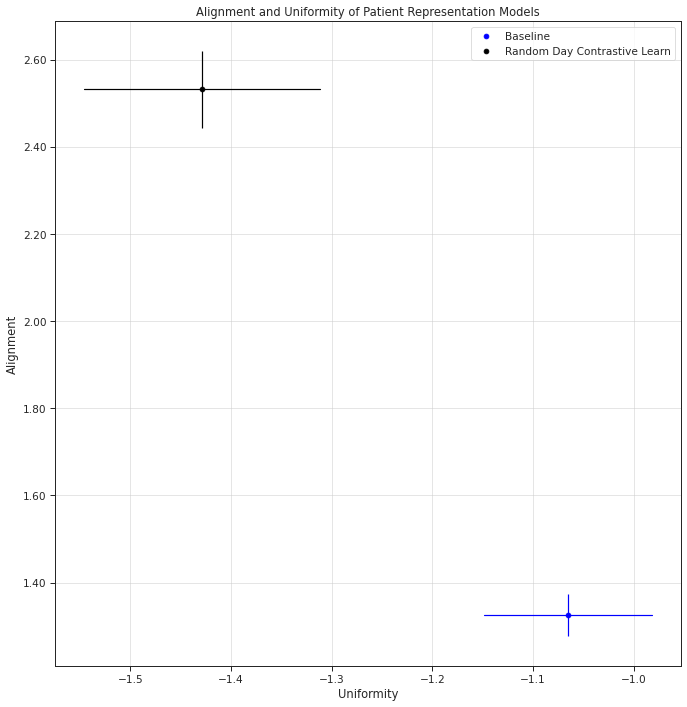

In [40]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
plt.tight_layout(w_pad=1,h_pad=2,rect=[0.05,0.15,1,0.95])


bl_evals = bl_df.query('split=="test"')
cl_evals = cl_df.query('split=="test"')

bl_evals['upper_ci'] = (bl_evals['upper_ci'] - bl_evals['med_ci']).abs()
bl_evals['lower_ci'] = (bl_evals['med_ci'] - bl_evals['lower_ci']).abs()

print(bl_evals)

cl_evals['upper_ci'] = (cl_evals['upper_ci'] - cl_evals['med_ci']).abs()
cl_evals['lower_ci'] = (cl_evals['med_ci'] - cl_evals['lower_ci']).abs()

print(cl_evals)

p1 = axes.scatter(
    bl_evals.query('metric=="uniformity"')['med_ci'],
    bl_evals.query('metric=="alignment"')['med_ci'],
    color = 'blue'
)

axes.errorbar(
    bl_evals.query('metric=="uniformity"')['med_ci'],
    bl_evals.query('metric=="alignment"')['med_ci'],
    bl_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='blue'
)

axes.plot(
    [bl_evals.query('metric=="uniformity"')['med_ci'] - bl_evals.query('metric=="uniformity"')['lower_ci'],bl_evals.query('metric=="uniformity"')['med_ci'] + bl_evals.query('metric=="uniformity"')['upper_ci']],
    [bl_evals.query('metric=="alignment"')['med_ci'], bl_evals.query('metric=="alignment"')['med_ci']],
    color='blue'
)

p2 = axes.scatter(
    cl_evals.query('metric=="uniformity"')['med_ci'],
    cl_evals.query('metric=="alignment"')['med_ci'],
    color = 'black'
)

axes.errorbar(
    cl_evals.query('metric=="uniformity"')['med_ci'],
    cl_evals.query('metric=="alignment"')['med_ci'],
    cl_evals.query('metric=="alignment"')[['lower_ci', 'upper_ci']].values.T,
    color='black'
)

axes.plot(
    [cl_evals.query('metric=="uniformity"')['med_ci'] - cl_evals.query('metric=="uniformity"')['lower_ci'], cl_evals.query('metric=="uniformity"')['med_ci'] + cl_evals.query('metric=="uniformity"')['upper_ci']],
    [cl_evals.query('metric=="alignment"')['med_ci'], cl_evals.query('metric=="alignment"')['med_ci']],
    color='black'
)

# axes.yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
axes.grid(which='major', linewidth=0.5, axis='y')
axes.grid(which='major', linewidth=0.5, axis='x')

axes.set_title('Alignment and Uniformity of Patient Representation Models')


axes.set_xlabel('Uniformity')
# axes.spines['bottom'].set_color('white')
# axes.tick_params(axis='x', length=0)  
axes.set_ylabel('Alignment')
axes.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes.legend([p1,p2],['Baseline','Random Day Contrastive Learn'])


# axes.spines['left'].set_color('white')
# axes.tick_params(axis='y', length=0)
# sns.despine(offset=10, trim=True,)


plt.savefig('figures/uni_align_eval.png', bbox_inches='tight')
plt.show()
